# Data "Munging"

Inputs to MODFLOW must be specified using the parameterization and methods described in each package's documentation. 
In a few cases, the data needs of MODFLOW will match very well with a pre-defined data source. For example:
* The top of MODFLOW layer 1 (FloPy Layer 0) is often treated as the land surface, which can be pulled directly from DEM data or interpolated with reasonable ease
* The bottom of the last MODFLOW layer is often treated as a no-flow boundary representing low-permeability bedrock. This can often be interpolated from well records or geophysical data.

In many cases, though, the inputs needed by stress MODFLOW must be converted, created, or otherwise ["munged"](https://en.wikipedia.org/wiki/Mung_(computer_term)) from existing data sources. For the purposes of MODFLOW, data munging steps often include:
* Importing or downloading data from the most reliable available source, and mapping the data onto the defined MODFLOW grid
* Transforming data to appropriate coordinate reference systems / EPSG codes
* Interpolating data or removing "no data" values to deal with data gaps
* Averaging or summing data to appropriate timesteps used within the MODFLOW model

This notebook demonstrates some aspects of data munging. The notebook is heavily based on a workbook from the [Python for Hydrology workshop](https://github.com/DOI-USGS/python-for-hydrology/tree/main) offered by Mike Fienen and others at the USGS.

## Learning Objectives

After you have read and run this notebook, you should be able to:
* Convert between coordinate systems with GeoPandas
* Use available Python and Numpy tools to interpolate / extrapolate or replaced data as necessary


## Initial Setup

As usual, we will import all necessary packages used in this workbook first.

In [153]:
import flopy
import flopy.utils as fpu
import flopy.discretization as fpd

from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.gridgen import Gridgen
from flopy.utils import GridIntersect, Raster

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os

data_path = os.path.join('.','nbinput','sagehen_munging')
model_path = os.path.join('.','models','sagehen_munging')


# Example of the Sagehen Creek

The code below demonstrates several aspects of data munging applied to generate a model for Sagehen Creek near Truckee, CA.
The modeler in this case has chosen to use the watershed boundaries for the stream gage found here: [USGS gage 10343500](https://waterdata.usgs.gov/ca/nwis/uv/?site_no=10343500&PARAmeter_cd=00065,00060) 

## Munge 1: Importing, viewing, and modifying shapefile CRSs to define an active area

In this part of the lesson we will intersect geospatial data with a modelgrid and begin building a simple adaptation of the Sagehen Creek model, near Truckee, CA. While building this model, we'll work with shapefile and raster data. As we build the model FloPy's intersection capabilities will be presented.

Let's start by getting the basin boundary. For the Sagehen Creek model, we're interested in the contributing area for [USGS gage 10343500](https://waterdata.usgs.gov/ca/nwis/uv/?site_no=10343500&PARAmeter_cd=00065,00060) 

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

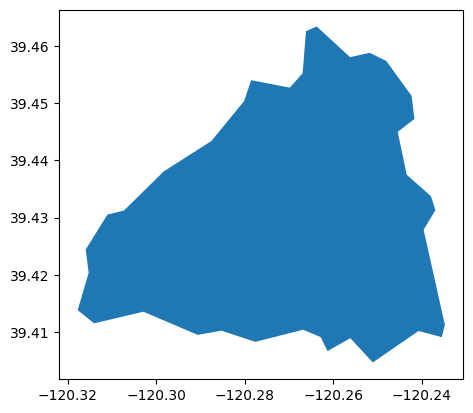

In [154]:
#Set the number of the station manually (not included in GIS shapefile)
station_id = "10343500"
#Define the Path to the shapefile
basinfile = os.path.join(data_path,"sagehen_basin.shp")
#Read the shapefile using geopandas
basin = gpd.read_file(basinfile)
#Set the identifier / key used by geopandas so that there's some record of where this data is associated with
basin = basin.set_index("identifier")
#Display the basin and the coordinate reference system information
basin.plot()
basin.crs

MODFLOW models must always be specified in terms of defined length units and time units. Since this model is represented in degrees (which are not a length unit), we need to perform a coordinate system transformation.

This is accomplished for this case using the `.to_crs()` method supplied within GeoPandas. We can double-check that the epsg code we have chosen is a reasonable transformation by looking at the crs information after transforming.

**Because we are inherently defining the length units here as meters, this should be documented in our MODFLOW model later**

<Projected CRS: EPSG:26911>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 120°W and 114°W - onshore and offshore. Canada - Alberta; British Columbia; Northwest Territories; Nunavut. United States (USA) - California; Idaho; Nevada, Oregon; Washington.
- bounds: (-120.0, 30.88, -114.0, 83.5)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

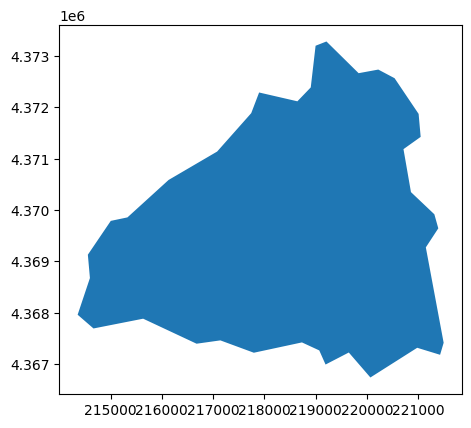

In [155]:
epsg = 26911  # NAD83 utm zone 11 N, epsg: 26911
basin = basin.to_crs(epsg=epsg)
basin.plot()
basin.crs

GeoPandas' `.bounds`, property allows one to find the extent of the region covered by each shape in the shapefile, which provides useful information for defining the model grid

In [156]:
bounds = basin.bounds
print(bounds)
xmin = bounds.loc[station_id, "minx"] - (cellsize * 1)
ymin = bounds.loc[station_id, "miny"] - (cellsize * 1)
xmax = bounds.loc[station_id, "maxx"] + (cellsize * 1)
ymax = bounds.loc[station_id, "maxy"] + (cellsize * 1)

                     minx          miny           maxx          maxy
identifier                                                          
10343500    214358.156816  4.366734e+06  221497.087128  4.373287e+06


We now have the information necessary to munge the data into the format that FloPy / MODFLOW want for at least a 1-layer structured grid.

Recall, MODFLOW defines the grid in terms of:
* The lower-left corner, which represents the minimum values for both x and y dimensions.
* The number of cells in each direction
* The size of the cells in each direction

So, we munge the information from the shapefile bounds in order to supply the inputs in the format that MODFLOW wants, assuming a cell size of 90 meters.
**At this point, it is a best practice to document the length units that are used in the CRS**

Lastly, to use the shapefile for its original purpose, we want to deactivate cells that do not fall within the basin.
Recall that, in MODFLOW the `ibound` or `idomain` property (in the case of MODFLOW 6) is what's used to determine active cells. From the MODFLOW 6 documentation:

![MODFLOW6_doc_idomain](./doc_materials/MODFLOW6_doc_idomain.png 'MODFLOW 6 documentation of the idomain variable')


We use the utility `GridIntersect`, as demonstrated earlier, to intersect points, polygons, and polylines with modelgrid objects.The basin boundary will be intersected with the modelgrid to create the active and inactive extents of the model. The `.intersect()` method returns a numpy recarry with cellids, vertices, cell areas, and shapely polygon objects.

xll:214268.15681551897; yll:4366643.672008078; rotation:0.0; crs:EPSG:26911; units:meters; lenuni:2
Is Complete?:  True


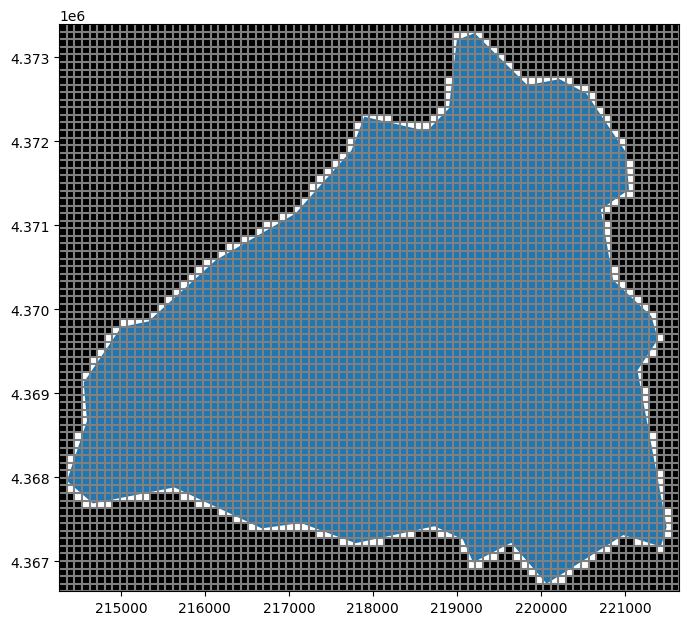

In [157]:
cellsize = 90  # 90 m grid
nlay = 1
lenuni = 2

east_length = xmax - xmin
north_length = ymax - ymin

nrow = np.ceil(north_length / cellsize).astype(int)
ncol = np.ceil(east_length / cellsize).astype(int)
delr = np.full((ncol,), cellsize)
delc = np.full((nrow,), cellsize)

# Set the top and bottom of the model as constant for now.
top = np.full((nrow, ncol), 100)
botm = np.full((nlay, nrow, ncol), 0)

modelgrid = flopy.discretization.StructuredGrid(
    delc,
    delr,
    nrow=nrow,
    ncol=ncol,
    nlay=nlay,
    top=top,
    botm=botm,
    xoff=xmin,
    yoff=ymin,
    crs=epsg,
    lenuni=lenuni,
    idomain=ibound
)

print(modelgrid)
print('Is Complete?: ', modelgrid.is_complete)
fig, ax = plt.subplots(figsize=(8, 8))
#Use FloPy to plot everything about the modelgrid
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_ibound()
pmv.plot_grid()
#Use in-built plot feature of GeoPandas to plot the shapefile
basin.plot(ax=ax)

#Use the GridIntersect tool to find which cells overlap with the basin shapefile
gx = GridIntersect(modelgrid)
#TODO: Investigate this function and its options.
result = gx.intersect(basin.loc[station_id, "geometry"])
result.cellids
#We start with all cells inactive, and activate only those cells that fall within the intersection
ibound = np.zeros((nlay, nrow, ncol))
i, j = zip(*result.cellids)
ibound[:, i, j] = 1

## Munge 2: Interpolating single-band raster (DEM) onto the modelgrid

Raster datasets are also associated with a specific coordinate reference system, and may also need to be rotated / translated into different CRSs. The simplest type of raster is a single-band raster that only contains one datapoint per pixel (e.g., DEMs)

In this second step, we use the `.to_crs()` method of the raster class to re-map the raster data into the coordinate system we're using. This is then mapped onto the modelgrid using the `.resample_to_grid()` method.

EPSG:4326


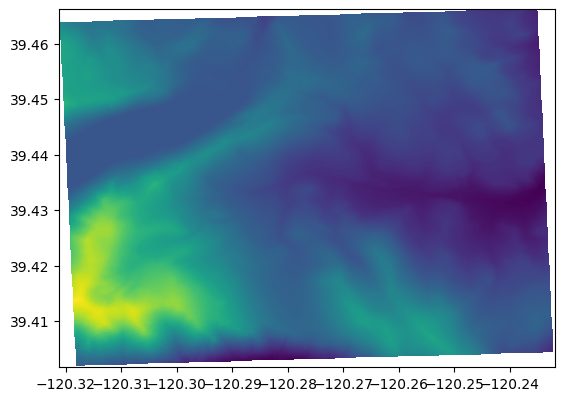

EPSG:26911


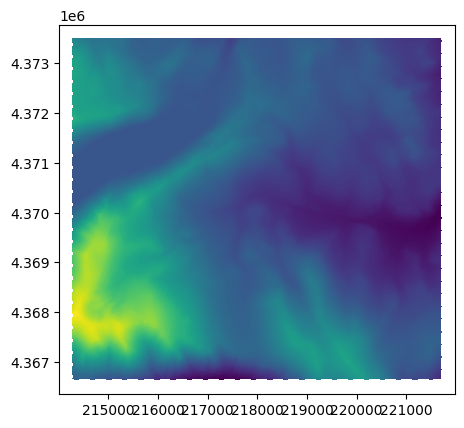

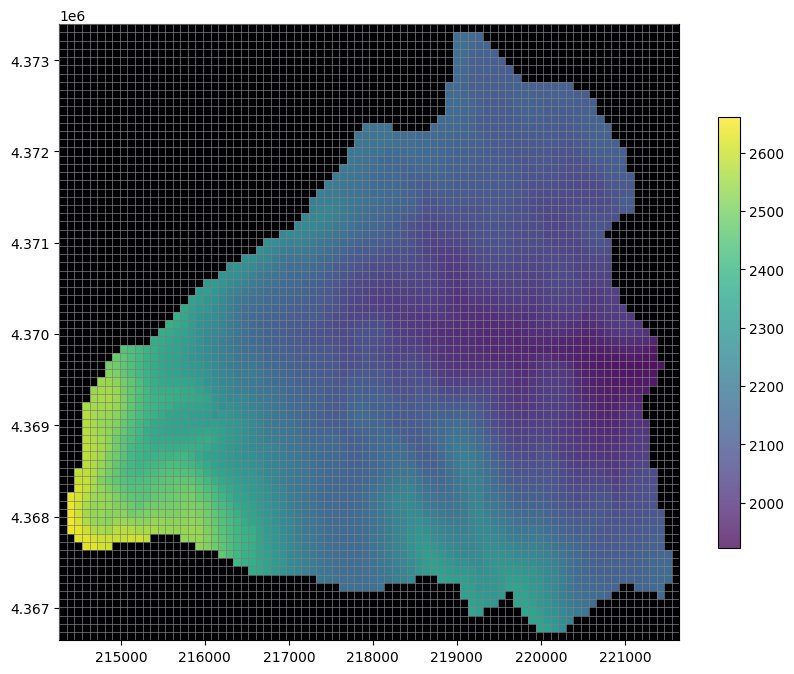

In [158]:
dem_file = os.path.join(data_path,"dem_deg.tif")
raster = Raster.load(dem_file)
print(raster.crs)
raster.plot()

raster_trans = raster.to_crs(epsg=epsg)
print(raster_trans.crs)
raster_trans.plot()

#TODO: Investigate different options that can be used with this function
dem_data = raster_trans.resample_to_grid(
    modelgrid,
    band=raster_trans.bands[0],
    method="nearest"
)

fig, ax = plt.subplots(figsize=(10, 8)) 
pmv = flopy.plot.PlotMapView(ax=ax, modelgrid=modelgrid)

pmv.plot_grid(lw=0.5, zorder=3)
pc = pmv.plot_array(dem_data, alpha=0.75, zorder=1, cmap="viridis")
pmv.plot_array(ibound, masked_values=[1], cmap="magma", zorder=2)
plt.colorbar(pc, shrink=0.7);


## Munge 3: Importing and translating multi-band raster datasets

Stresses that apply over the grid and vary with time can be stored in multi-band rasters. The code below shows an example where monthly potential evapotranspiration (PET) and precipitation are loaded from a multi-band raster.

Most time-series FloPy inputs are represented through dictionary (dict) datatypes, where the key represents the stress period and the value represents the data defining the stress. This code below introduces another complication in that the rasters contain "no data" values that would be misinterpreted if pulled directly into MODFLOW.

You must know what units your raster is in (this information is not stored in the raster data structure). For the data used here, we know that the units are mm/day. We plan to create a model in m/day, so now is a good time to perform the units conversion

In [159]:
prcp = os.path.join(data_path,"prcp.tif")

#Double-check the CRS for the data
prcp_rstr = flopy.utils.Raster.load(prcp)
print(prcp_rstr.crs)

#Check to see if there are any nodata values in the raster
print('No data value:', prcp_rstr.nodatavals)
print('Bands: ', prcp_rstr.bands)

#Most time-series data that goes into flopy should be supplied as a dict where the
#key is the stress period and the value is the data for that stress period
#The prcp_monthly dict created below 
prcp_monthly = {}
for band in prcp_rstr.bands:
    pr_month = prcp_rstr.resample_to_grid(
        modelgrid,
        band,
        method="nearest"
    )
    #In this case, we are assuming that if there is no data for a given pixel, we should assume there was
    #no precipitation. This is a user choice!
    pr_month[pr_month == prcp_rstr.nodatavals[0]] = 0
    #And now, we are ensuring that we have converted the units to m/day
    prcp_monthly[band - 1] = t*0.001


EPSG:26911
No data value: (3.4028234663852886e+38,)
Bands:  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)


In [160]:
pet = os.path.join(data_path,"pet.tif")

#Double-check the CRS for the data
pet_rstr = flopy.utils.Raster.load(prcp)
print(pet_rstr.crs)

#Check to see if there are any nodata values in the raster
print('No data value:', pet_rstr.nodatavals)
print('Bands: ', pet_rstr.bands)

#Most time-series data that goes into flopy should be supplied as a dict where the
#key is the stress period and the value is the data for that stress period
#The prcp_monthly dict created below 
pet_monthly = {}
for band in pet_rstr.bands:
    pet_month = pet_rstr.resample_to_grid(
        modelgrid,
        band,
        method="nearest"
    )
    #In this case, we are assuming that if there is no data for a given pixel, we should assume there was
    #no precipitation. This is a user choice!
    pet_month[pet_month == pet_rstr.nodatavals[0]] = 0
    #And now, we are ensuring that we have converted the units to m/day
    pet_monthly[band - 1] = t*0.001

EPSG:26911
No data value: (3.4028234663852886e+38,)
Bands:  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)


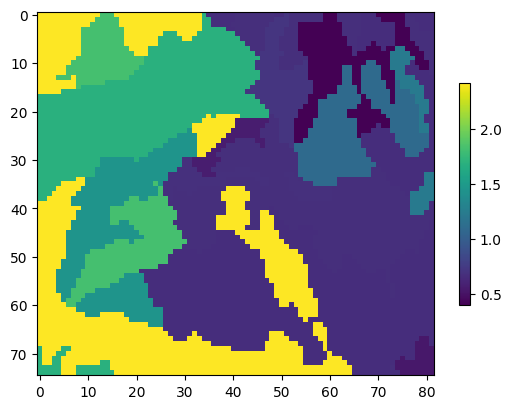

In [161]:
#Also we will import a raster of saturated hydraulic conductivity
ksat_raster = os.path.join(data_path,"ksat.img")
rstr = flopy.utils.Raster.load(ksat_raster)
vks = rstr.resample_to_grid(
    modelgrid,
    rstr.bands[0],
    method="nearest"
)
vks[vks == rstr.nodatavals[0]] = np.nan
vks[np.isnan(vks)] = np.nanmean(vks)
vks *= 0.0864  # um per sec to m per day
ims = plt.imshow(vks)
plt.colorbar(shrink=0.6); 

In [163]:
#Create all of the standard packages needed for every MODFLOW model
sim = flopy.mf6.MFSimulation("sagehen", sim_ws=model_path)
ims = flopy.mf6.ModflowIms(sim, complexity="COMPLEX")
nper = 12
perlen = (31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)
period_data = [(i, i, 1.0) for i in perlen]
tdis = flopy.mf6.ModflowTdis(
    sim,
    nper=12,
    perioddata=period_data,
    time_units="days"
)

gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname='sagehen',
    save_flows=True,
)

modelgrid = gwf.modelgrid
modelgrid.set_coord_info(xoff=xmin, yoff=ymin)

# add the dis package
botm = np.expand_dims(dem_data, axis=0) - 200
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nrow=nrow,
    ncol=ncol,
    delr=modelgrid.delr,
    delc=modelgrid.delc,
    top=dem_data,
    botm=botm,
    idomain=ibound
)

ic = flopy.mf6.ModflowGwfic(gwf, strt=dem_data - 5)
gwf

npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    save_specific_discharge=True,
    k=0.022  # value from Larsen et al, 2022
)

sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=1,
    ss=1e-07,  # values from Larsen et al, 2022
    sy=0.2
)

budget_file = "sagehen.cbc"
head_file = "sagehen.hds"
saverecord = {i: [("HEAD", "ALL"), ("BUDGET", "ALL")] for i in range(gwf.nper)}
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=budget_file,
    head_filerecord=head_file,
    saverecord=saverecord,
)

AttributeError: 'Grid' object has no attribute 'delr'

In [ ]:
package_data = []
cnt = 0
for i in range(modelgrid.nrow):
    for j in range(modelgrid.ncol):
        if modelgrid.idomain[0, i, j] == 0:
            continue
        
        rec = (cnt, (0, i, j), 1, 0, 1.0, vks[i, j], 0.1, 0.38, 0.1, 3.5)
        package_data.append(rec)
        cnt += 1

period_data = {}
for per in range(gwf.nper):
    spd = []
    cnt = 0
    for i in range(modelgrid.nrow * modelgrid.ncol):
        if modelgrid.idomain.ravel()[i] == 0:
            continue
        rec = (cnt, prcp_monthly[per].ravel()[i], pet_monthly[per].ravel()[i], 0.5, 0.2, -1.1, -75, 1.0)
        spd.append(rec)
        cnt += 1
        
    period_data[per] = spd

#### Creating a UZF package 

Now that we have some climate and soils data we can create a UZF package from it and add it to the model!

Create the package data and the stress period data info for flopy

For the package data we are making some basic assumptions. `landflag=1` and `ivertcon=0` meaning that the cell is at the surface and is not connected to an underlying uzf cell. The `surfdep=1.0` which means that we have a surface depression (variable land surface) of 1 meter for all cells. `thtr=0.1`, `thts=0.38` meaning the soil is fairly porous and transmits water readily. `thti=0.1` which means initial conditions are residual water content. And finally a brooks-corey epsilon `eps=3.5`. 

For the stress period data, some additional assumptions are made. `extdp=0.5` which means that the evapotranspiration extinction depth is 0.5 m below the surface. `extwc=0.2` which means that the extinction water content (low end of field capacity) is 0.2 (unitless or m^3/m^3). All other values are placeholders and are not used with the current simulation options.  

For more information about the UZF input options please see [UZF: online guide to MF6](https://modflow6.readthedocs.io/en/latest/_mf6io/gwf-uzf.html)

In [108]:
#Now is where we have to start looking into what the UZF package wants for inputs, and how to provide it through FloPy

modelgrid = gwf.modelgrid
modelgrid.set_coord_info(xoff=xmin, yoff=ymin)
package_data = []
cnt = 0
for i in range(modelgrid.nrow):
    for j in range(modelgrid.ncol):
        if modelgrid.idomain[0, i, j] == 0:
            continue
        # ifno, cellid, landflag, ivertcon, surfdep, vks, thtr, thts, thti, eps
        rec = (cnt, (0, i, j), 1, 0, 1.0, vks[i, j], 0.1, 0.38, 0.1, 3.5)
        package_data.append(rec)
        cnt += 1

period_data = {}
for per in range(gwf.nper):
    spd = []
    cnt = 0
    for i in range(modelgrid.nrow * modelgrid.ncol):
        if modelgrid.idomain.ravel()[i] == 0:
            continue
        # ifno, finf, pet, extdp, extwc, [ha, hroot, rootact] in record, but not simulated
        rec = (cnt, prcp_monthly[per].ravel()[i], pet_monthly[per].ravel()[i], 0.5, 0.2, -1.1, -75, 1.0)
        spd.append(rec)
        cnt += 1
        
    period_data[per] = spd


{0: [(0,
   np.float64(3.56935453414917),
   np.float64(0.0),
   0.5,
   0.2,
   -1.1,
   -75,
   1.0),
  (1, np.float64(3.56935453414917), np.float64(0.0), 0.5, 0.2, -1.1, -75, 1.0),
  (2, np.float64(3.56935453414917), np.float64(0.0), 0.5, 0.2, -1.1, -75, 1.0),
  (3, np.float64(3.56935453414917), np.float64(0.0), 0.5, 0.2, -1.1, -75, 1.0),
  (4,
   np.float64(3.658064365386963),
   np.float64(0.0),
   0.5,
   0.2,
   -1.1,
   -75,
   1.0),
  (5, np.float64(3.56935453414917), np.float64(0.0), 0.5, 0.2, -1.1, -75, 1.0),
  (6, np.float64(3.56935453414917), np.float64(0.0), 0.5, 0.2, -1.1, -75, 1.0),
  (7, np.float64(3.56935453414917), np.float64(0.0), 0.5, 0.2, -1.1, -75, 1.0),
  (8, np.float64(3.56935453414917), np.float64(0.0), 0.5, 0.2, -1.1, -75, 1.0),
  (9,
   np.float64(3.658064365386963),
   np.float64(0.0),
   0.5,
   0.2,
   -1.1,
   -75,
   1.0),
  (10,
   np.float64(3.658064365386963),
   np.float64(0.0),
   0.5,
   0.2,
   -1.1,
   -75,
   1.0),
  (11,
   np.float64(3.569354

In [ ]:
uzf = flopy.mf6.ModflowGwfuzf(
    gwf,
    simulate_et=True,
    ntrailwaves=15,
    nwavesets=100,
    packagedata=package_data,
    perioddata=period_data,
    unsat_etwc=True,
    linear_gwet=True,
    simulate_gwseep=True
)

### Now to create a simple river package from NHD flowlines 

We can use the intersection routines that have been presented thus far to create a river package for the sagehen model. 

The first step is load the NHD flowlines for the basin

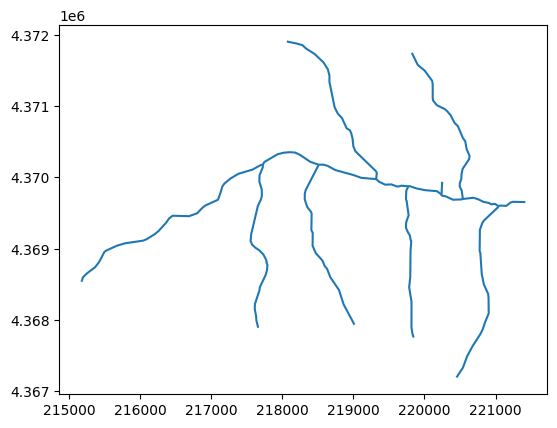

In [57]:
flow_lines = os.path.join(data_path,"sagehen_nhd.shp")
flw_all = gpd.read_file(flow_lines)
flw_all.plot();

Excellent! Now we have all of the flow lines for the Sagehen watershed. But what if we want to identify the main stem? 

In [ ]:
flow_lines = os.path.join(data_path,"sagehen_main_nhd.shp")
flw_main = gpd.read_file(flow_lines)
flw_main.plot()
flw_main

Great! Now we can start processing data to create a river package. We can first identify our main stem cells.

In [ ]:
main_stem = []
gx = GridIntersect(modelgrid)
for iloc, row in flw_main.iterrows():
    results = gx.intersect(row.geometry)
    main_stem += list(results.cellids)
main_stem[0:5]

## Class Exercise:

Use GridIntersect to create a list of tributary cells from the `flw_all` geodataframe. 

**Hint**
Use the `main_stem` list to filter out cells that are associated with the main stem of the river and only store the cells that are associated with tributaries to the main stem.

The cellids for tributaries have been stored previously, so we'll load those up and continue on.


In [41]:
tributaries = []
with open(os.path.join(data_path,"trib_cells.txt")) as foo:
    for line in foo:
        t = line.strip().split(",")
        tributaries.append((int(t[0]), int(t[1])))

#### We can also get daily discharge data to help calculate average monthly stages for the RIV package

We'll use the `dataretrieval` package to get stage information for our model

In [42]:
import dataretrieval.nwis as nwis

gage = nwis.get_record(sites=station_id, service='iv', start="2023-01-01", end="2023-12-31", parameterCd="00065")
gage.to_csv(os.path.join(data_path,"sagehen_gage_data.csv"))

,site_no,stage,00065_cd
datetime,,,
2023-01-01 08:00:00+00:00,10343500,0.748752,A
2023-01-01 08:15:00+00:00,10343500,0.748752,A
2023-01-01 08:30:00+00:00,10343500,0.748752,A
2023-01-01 08:45:00+00:00,10343500,0.748752,A
2023-01-01 09:00:00+00:00,10343500,0.748752,A


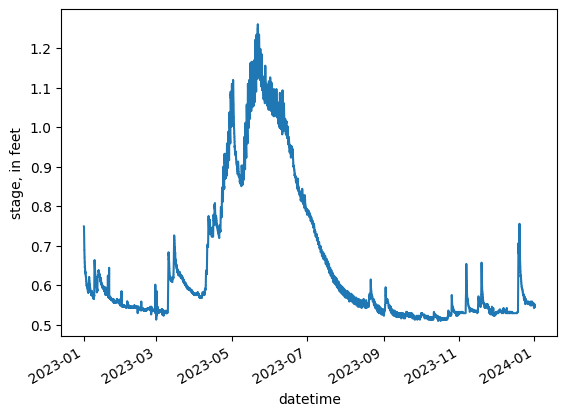

In [43]:
gage = pd.read_csv(os.path.join(data_path,"sagehen_gage_data.csv"))
gage["datetime"] = pd.to_datetime(gage["datetime"])
gage = gage.set_index("datetime")

gage.rename(columns={"00065": "stage"}, inplace=True)
gage.stage *= 0.3284
ax = gage.stage.plot()
ax.set_ylabel("stage, in feet")
gage.head()

Now we can aggregate to a mean monthly stage from 15 minute instantaneous values

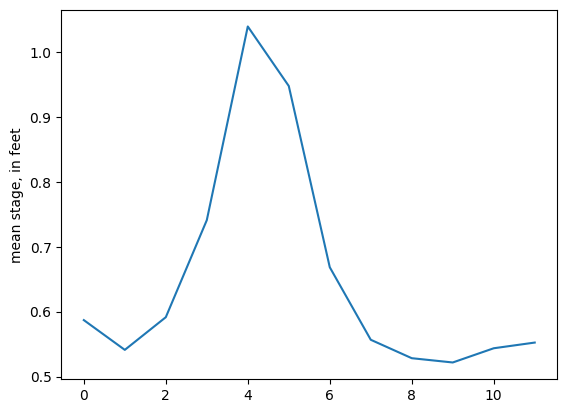

In [44]:
gage["month"] = gage.index.month
gage_mmo = gage.groupby(by=["month"], as_index=False)["stage"].mean()
ax = gage_mmo.stage.plot()
ax.set_ylabel("mean stage, in feet");

### Now to create the RIV package


In [45]:
cond = 10
rbadj = 1
stage_adj = 0.33

perioddata = {}
for kper, row in gage_mmo.iterrows():
    spd = []
    for (i, j) in main_stem:
        ctop = modelgrid.top[i, j]
        rbed = ctop - rbadj
        rec = ((0, i, j), row.stage + rbed, cond, rbed)
        spd.append(rec)
        
    for (i, j) in tributaries:
        ctop = modelgrid.top[i, j]
        rbed = ctop - (rbadj / 2)
        rec = ((0, i, j), row.stage + rbed, cond, rbed)
        spd.append(rec)
    
    perioddata[kper] = spd

perioddata[0][0:5]

NameError: name 'main_stem' is not defined

In [46]:
riv = flopy.mf6.ModflowGwfriv(
    gwf,
    save_flows=True,
    maxbound=len(perioddata[0]),
    stress_period_data=perioddata
)


KeyError: 0

# Testing the model

In [47]:
sim.write_simulation()
sim.run_simulation();

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model sagehen...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../../opt/anaconda3/envs/geosci724/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

        MODFLOW 6 compiled Dec 23 2024 16:29:44 with GCC version 12.4.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government 

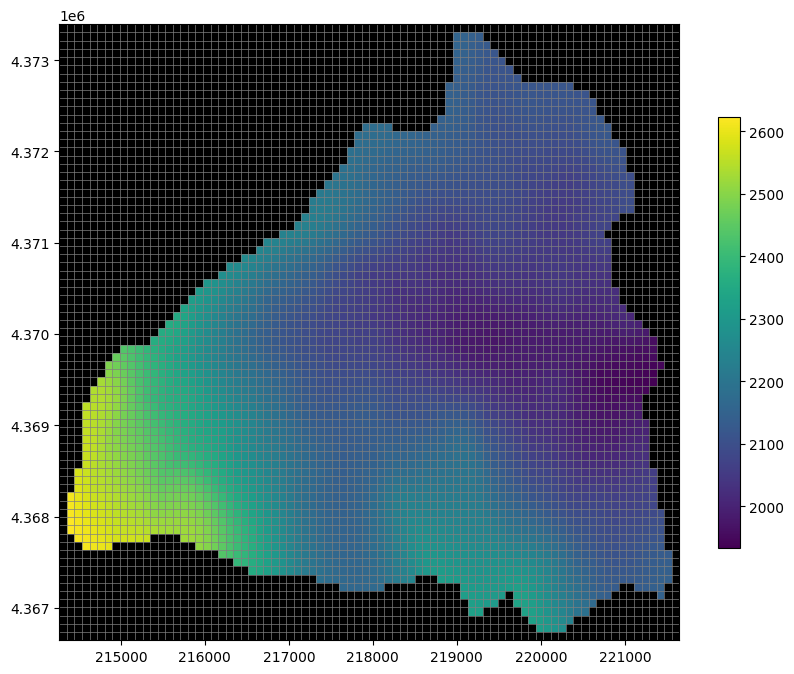

In [48]:
hds = gwf.output.head()
heads = hds.get_alldata()[-1]

fig, ax = plt.subplots(figsize=(10, 8))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(heads, cmap='viridis', masked_values=[1e30, -1e30])
pmv.plot_grid(lw=0.5)
pmv.plot_inactive()
plt.colorbar(pc, shrink=0.7)
plt.show();

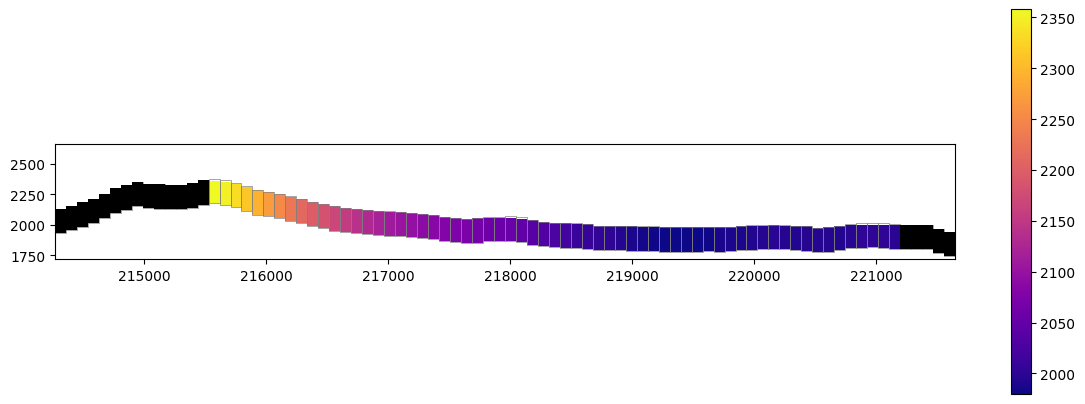

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_aspect("equal")
xc = flopy.plot.PlotCrossSection(modelgrid=modelgrid, ax=ax, line={"row": 36}, geographic_coords=True)
pc = xc.plot_array(heads, cmap='plasma', head=heads, masked_values=[1e+30])
xc.plot_grid(lw=0.5)
xc.plot_inactive()
plt.colorbar(pc, shrink=0.50)
plt.tight_layout();